# motion estimation in spikeinterface

In 2021,the SpikeInterface project has started to implemented `sortingcomponents`, a modular module for spike sorting steps.

Here is an overview or our progress integrating motion (aka drift) estimation and correction.


This notebook will be based on the open dataset from Nick Steinmetz published in 2021
"Imposed motion datasets" from Steinmetz et al. Science 2021
https://figshare.com/articles/dataset/_Imposed_motion_datasets_from_Steinmetz_et_al_Science_2021/14024495


The motion estimation is done in several modular steps:
  1. detect peaks
  2. localize peaks:
     * **"center of of mass"**
     * **"monopolar_triangulation"** by Julien Boussard and Erdem Varol
       https://openreview.net/pdf?id=ohfi44BZPC4
  3. estimation motion:
     * **rigid** or **non rigid**
     * **"decentralize"** by Erdem Varol and  Julien Boussard
       DOI : 10.1109/ICASSP39728.2021.9414145
     * **"motion cloud"** by Julien Boussard (not implemented yet)


Here we will show this chain:
* **detect peak > localize peaks with "monopolar_triangulation" > estimation motion "decentralize"**










In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import spikeinterface.full as si

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 12)

from probeinterface.plotting import plot_probe


from spikeinterface.sortingcomponents import detect_peaks
from spikeinterface.sortingcomponents import localize_peaks

In [3]:
# local folder
base_folder = Path('/mnt/data/sam/DataSpikeSorting/imposed_motion_nick')

dataset_folder = base_folder / 'dataset1/NP1'
preprocess_folder = base_folder / 'dataset1_NP1_preprocessed'
peak_folder = base_folder / 'dataset1_NP1_peaks'

peak_folder.mkdir(exist_ok=True)

In [4]:
# global kwargs for parallel computing
job_kwargs = dict(
    n_jobs=40,
    chunk_memory='10M',
    progress_bar=True,
)

In [5]:
# read the file
rec = si.read_spikeglx(dataset_folder)
rec

SpikeGLXRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 1957.191s

(-150.0, 200.0)

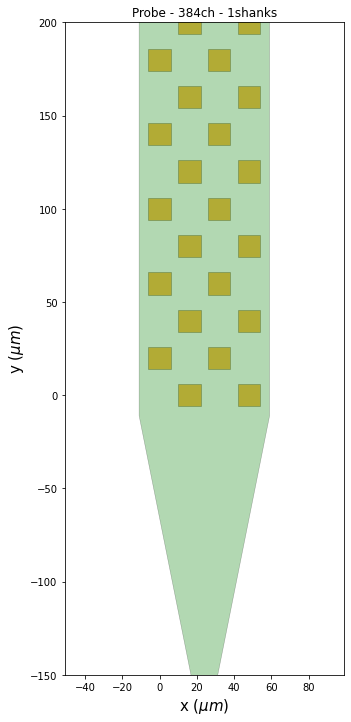

In [11]:
fig, ax = plt.subplots()
plot_probe(rec.get_probe(), ax=ax)
ax.set_ylim(-150, 200)

## preprocess

This take 4 min for 30min of signals

In [7]:
rec_filtered = si.bandpass_filter(rec, freq_min=300., freq_max=6000.)
rec_preprocessed = si.common_reference(rec_filtered, reference='global', operator='median')
rec_preprocessed.save(folder=preprocess_folder, **job_kwargs)

write_binary_recording with n_jobs 40  chunk_size 13020


write_binary_recording: 100%|██████████| 4510/4510 [03:25<00:00, 21.96it/s]


BinaryRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 1957.191s
  file_paths: ['/mnt/data/sam/DataSpikeSorting/imposed_motion_nick/dataset1_NP1_preprocessed/traces_cached_seg0.raw']

In [5]:
# load back
rec_preprocessed = si.load_extractor(preprocess_folder)
rec_preprocessed

BinaryRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 1957.191s
  file_paths: ['/mnt/data/sam/DataSpikeSorting/imposed_motion_nick/dataset1_NP1_preprocessed/traces_cached_seg0.raw']

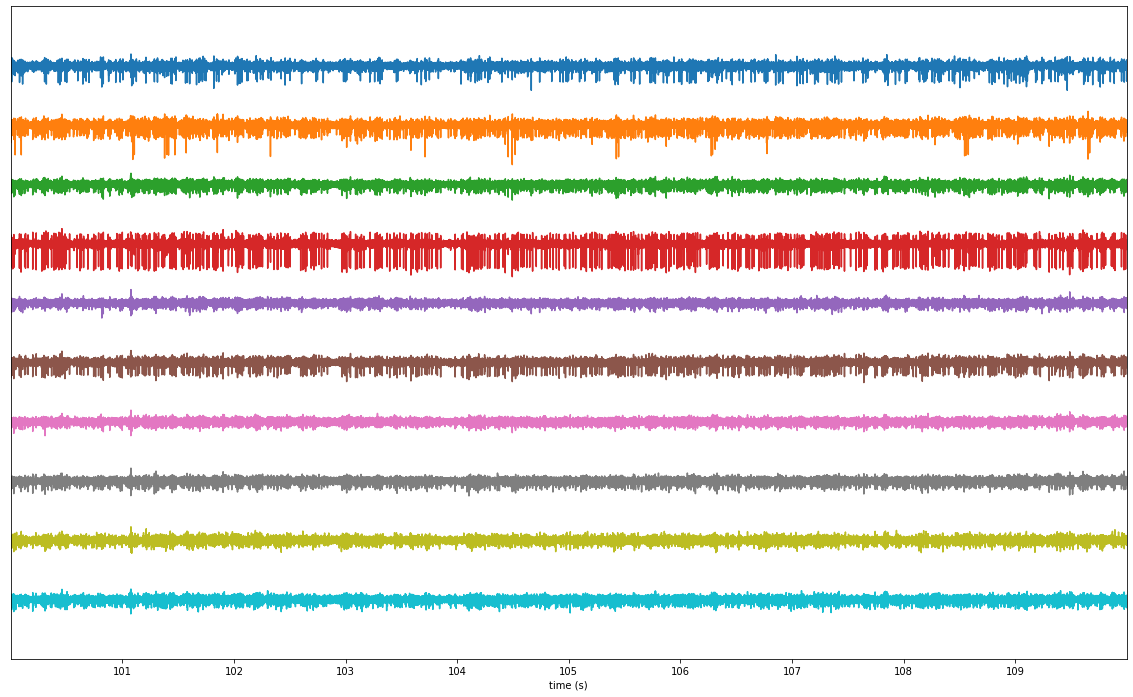

In [12]:
# plot and check spikes
si.plot_timeseries(rec_preprocessed, time_range=(100, 110), channel_ids=rec.channel_ids[50:60])

## estimate noise

Text(0.5, 1.0, 'noise across channel')

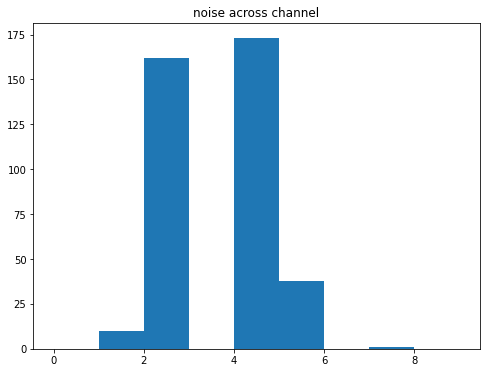

In [14]:
noise_levels = si.get_noise_levels(rec_preprocessed, return_scaled=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(noise_levels, bins=np.arange(0,10, 1))
ax.set_title('noise across channel')

## detect peaks

This take 1min30s

In [15]:
from spikeinterface.sortingcomponents import detect_peaks

In [16]:
peaks = detect_peaks(
    rec_preprocessed,
    method='locally_exclusive',
    local_radius_um=100,
    peak_sign='neg',
    detect_threshold=5,
    n_shifts=5,
    noise_levels=noise_levels,
    **job_kwargs,
)
np.save(peak_folder / 'peaks.npy', peaks)

detect peaks: 100%|██████████| 4510/4510 [01:31<00:00, 49.13it/s]


In [8]:
# load back
peaks = np.load(peak_folder / 'peaks.npy')
print(peaks.shape)

(4041217,)


## localize peaks

We use 2 methods:
  * 'center_of_mass': 9 s
  * 'monopolar_triangulation' : 26min

In [18]:
from spikeinterface.sortingcomponents import localize_peaks

In [19]:
peak_locations = localize_peaks(
    rec_preprocessed,
    peaks,
    ms_before=0.3,
    ms_after=0.6,
    method='center_of_mass',
    method_kwargs={'local_radius_um': 100.},
    **job_kwargs,
)
np.save(peak_folder / 'peak_locations_center_of_mass.npy', peak_locations)
print(peak_locations.shape)

localize peaks: 100%|██████████| 4510/4510 [00:09<00:00, 461.01it/s]


(4041217,)


In [20]:
peak_locations = localize_peaks(
    rec_preprocessed,
    peaks,
    ms_before=0.3,
    ms_after=0.6,
    method='monopolar_triangulation',
    method_kwargs={'local_radius_um': 100., 'max_distance_um': 1000.},
    **job_kwargs,
)
np.save(peak_folder / 'peak_locations_monopolar_triangulation.npy', peak_locations)
print(peak_locations.shape)

localize peaks:   0%|          | 2/4510 [00:13<10:43:51,  8.57s/it]

In [6]:
# load back
# peak_locations = np.load(peak_folder / 'peak_locations_center_of_mass.npy')
peak_locations = np.load(peak_folder / 'peak_locations_monopolar_triangulation.npy')
print(peak_locations)

[(  18.52504101, 1783.26060082,  80.56493564, 1736.54517744)
 (  75.90387896, 4135.11490531,   1.02883473, 4001.33816608)
 ( -23.97108877, 2632.738146  ,  87.2656153 , 2632.17702833) ...
 (  40.06415842, 1977.85847864,  26.4586952 , 1091.46159133)
 (-185.47200933, 1795.53548018, 155.37976473, 3492.17984483)
 (  58.83825019, 1178.6461218 ,  82.17022322, 1253.97375113)]


## plot peak on probe

(1500.0, 2500.0)

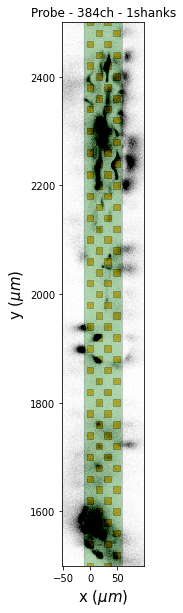

In [16]:
probe = rec_preprocessed.get_probe()

fig, ax = plt.subplots(figsize=(15, 10))
plot_probe(probe, ax=ax)
ax.scatter(peak_locations['x'], peak_locations['y'], color='k', s=1, alpha=0.002)
# ax.set_ylim(2400, 2900)
ax.set_ylim(1500, 2500)

## plot peak depth vs time

(1300.0, 2500.0)

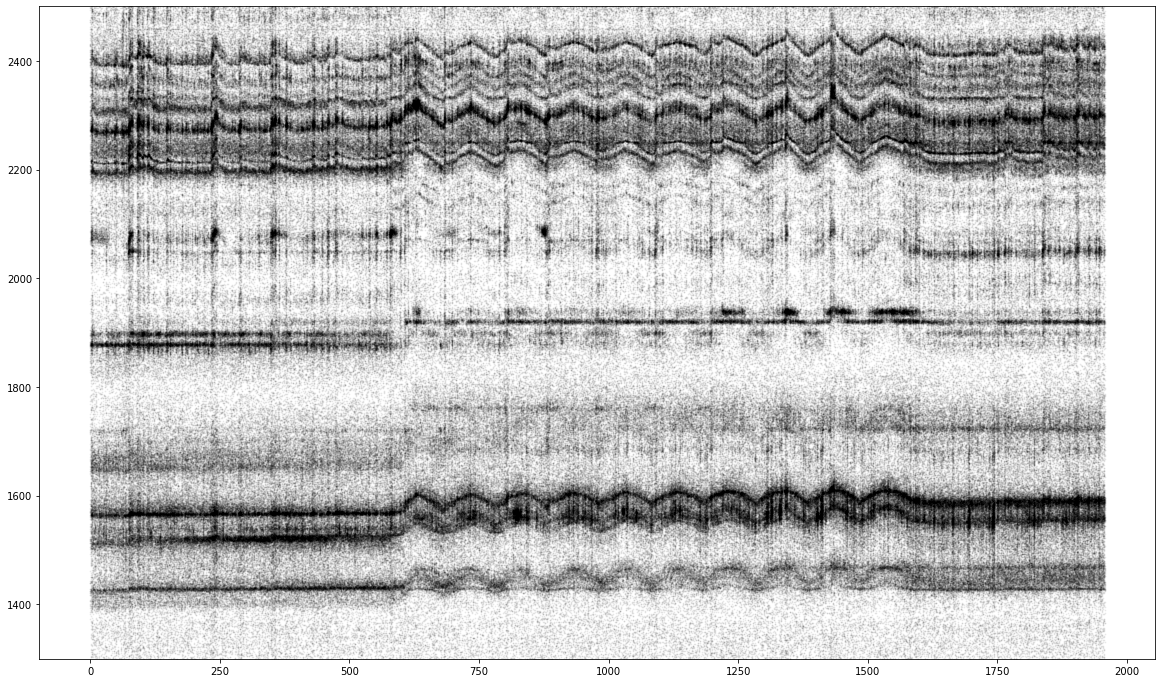

In [11]:
fig, ax = plt.subplots()
x = peaks['sample_ind'] / rec_preprocessed.get_sampling_frequency()
y = peak_locations['y']
ax.scatter(x, y, s=1, color='k', alpha=0.05)
ax.set_ylim(1300, 2500)

## motion estimate : rigid with decentralized

In [17]:
from spikeinterface.sortingcomponents import (
    estimate_motion,
    make_motion_histogram,
    compute_pairwise_displacement,
    compute_global_displacement
)

In [18]:
bin_um = 2
bin_duration_s=5.

motion_histogram, temporal_bins, spatial_bins = make_motion_histogram(
    rec_preprocessed,
    peaks,
    peak_locations=peak_locations, 
    bin_um=bin_um,
    bin_duration_s=bin_duration_s,
    direction='y',
    weight_with_amplitude=False,
)
print(motion_histogram.shape, temporal_bins.size, spatial_bins.size)


(392, 1960) 393 1961


Text(0, 0.5, 'depth[um]')

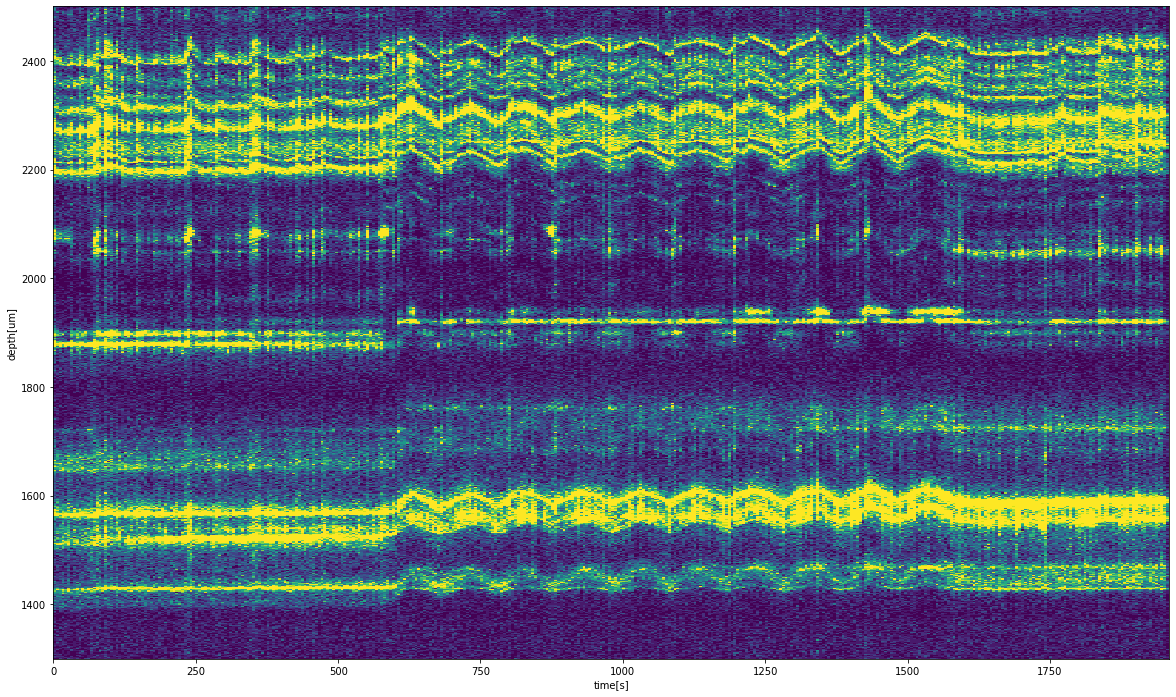

In [22]:
fig, ax = plt.subplots()
extent = (temporal_bins[0], temporal_bins[-1], spatial_bins[0], spatial_bins[-1])
im = ax.imshow(
    motion_histogram.T,
    interpolation='nearest',
    origin='lower',
    aspect='auto',
    extent=extent,
)
im.set_clim(0, 15)
ax.set_ylim(1300, 2500)
ax.set_xlabel('time[s]')
ax.set_ylabel('depth[um]')


## pariwise displacement from the motion histogram


In [23]:
pairwise_displacement = compute_pairwise_displacement(motion_histogram, bin_um, method='conv2d', )
np.save(peak_folder / 'pairwise_displacement_conv2d.npy', pairwise_displacement)


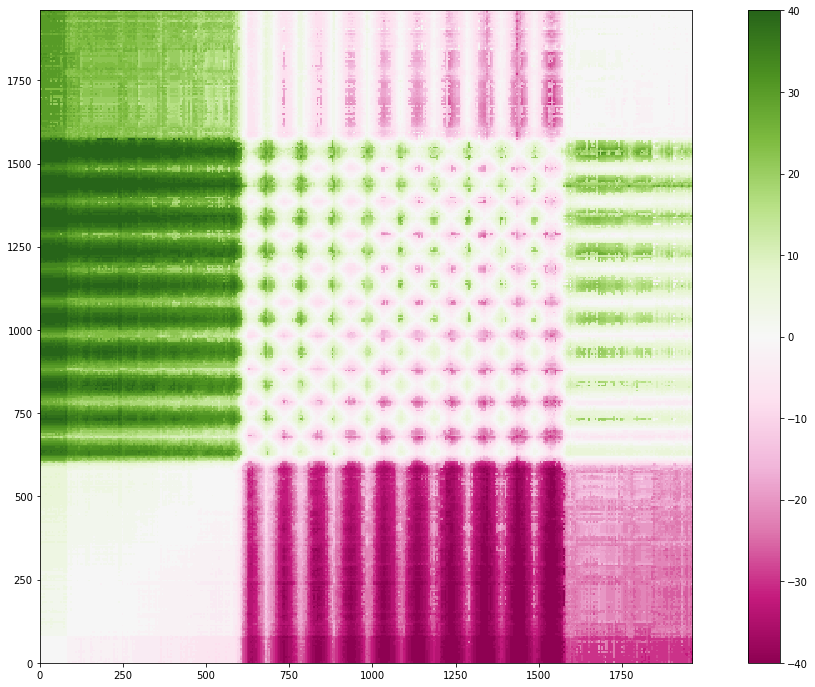

In [24]:
fig, ax = plt.subplots()
extent = (temporal_bins[0], temporal_bins[-1], temporal_bins[0], temporal_bins[-1])
# extent = None
im = ax.imshow(
    pairwise_displacement,
    interpolation='nearest',
    cmap='PiYG',
    origin='lower',
    aspect='auto',
    extent=extent,
)
im.set_clim(-40, 40)
ax.set_aspect('equal')
fig.colorbar(im)

## estimate motion (rigid) from the pairwise displacement

In [25]:
motion = compute_global_displacement(pairwise_displacement)

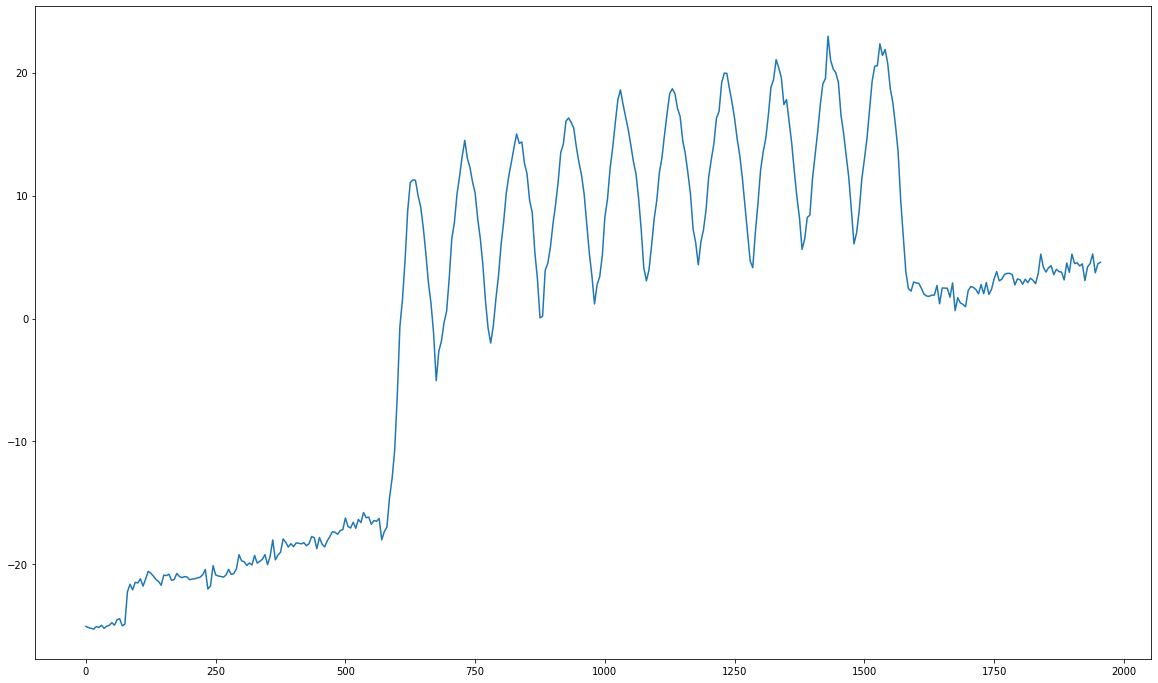

In [26]:
fig, ax = plt.subplots()
ax.plot(temporal_bins[:-1], motion)


## motion estimation with one unique funtion

Internally `estimate_motion()` does:
  * make_motion_histogram()
  * compute_pairwise_displacement()
  * compute_global_displacement()
  

In [27]:
motion, temporal_bins, spatial_bins = estimate_motion(
    rec_preprocessed,
    peaks,
    peak_locations=peak_locations,
    direction='y',
    bin_duration_s=5.,
    bin_um=10.,
    method='decentralized_registration',
    method_kwargs={},
    non_rigid_kwargs=None, 
    progress_bar=True,
    verbose=True,
)

make_motion_histogram
0
compute_pairwise_displacement 0


100%|██████████| 392/392 [00:06<00:00, 63.11it/s]


compute_global_displacement 0


Text(0, 0.5, 'motion [um]')

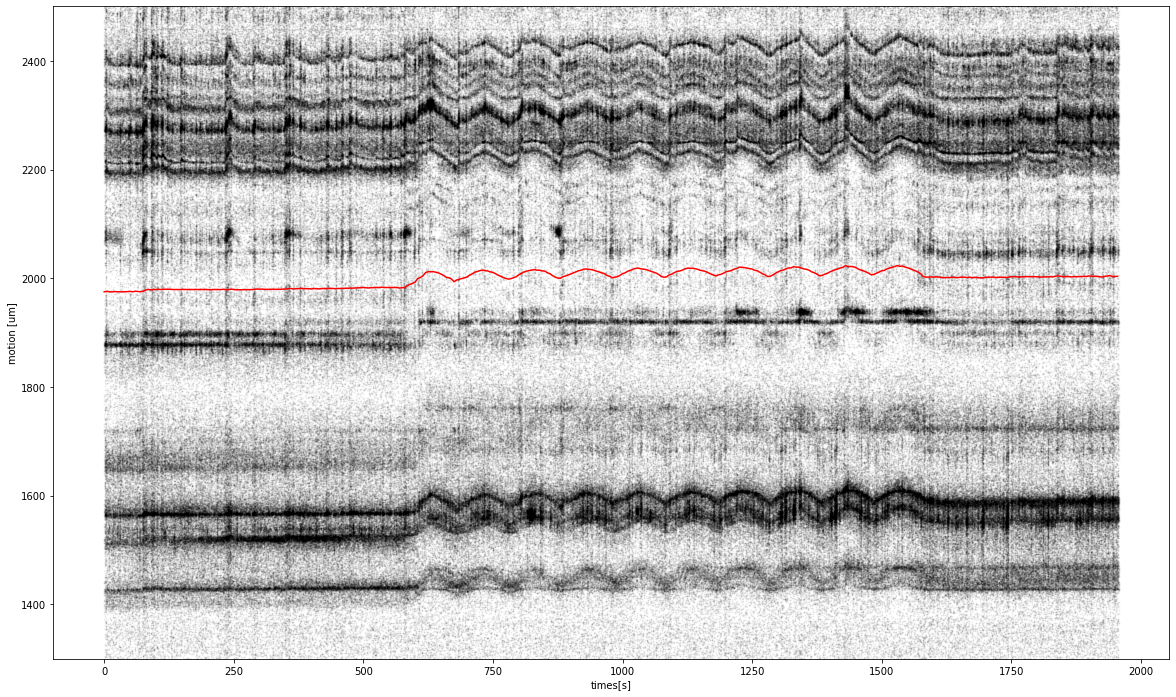

In [30]:
fig, ax = plt.subplots()
x = peaks['sample_ind'] / rec_preprocessed.get_sampling_frequency()
y = peak_locations['y']
ax.scatter(x, y, s=1, color='k', alpha=0.05)
ax.set_ylim(1300, 2500)


ax.plot(temporal_bins[:-1], motion + 2000, color='r')
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')

## motion estimation non rigid

make_motion_histogram
0
compute_pairwise_displacement 0


100%|██████████| 392/392 [00:06<00:00, 62.04it/s]


compute_global_displacement 0
1
compute_pairwise_displacement 1


100%|██████████| 392/392 [00:06<00:00, 63.56it/s]


compute_global_displacement 1
2
compute_pairwise_displacement 2


100%|██████████| 392/392 [00:06<00:00, 62.15it/s]


compute_global_displacement 2
3
compute_pairwise_displacement 3


100%|██████████| 392/392 [00:06<00:00, 63.35it/s]


compute_global_displacement 3
4
compute_pairwise_displacement 4


100%|██████████| 392/392 [00:06<00:00, 63.07it/s]


compute_global_displacement 4
5
compute_pairwise_displacement 5


100%|██████████| 392/392 [00:06<00:00, 63.13it/s]


compute_global_displacement 5
6
compute_pairwise_displacement 6


100%|██████████| 392/392 [00:06<00:00, 63.40it/s]


compute_global_displacement 6
7
compute_pairwise_displacement 7


100%|██████████| 392/392 [00:06<00:00, 62.72it/s]


compute_global_displacement 7
8
compute_pairwise_displacement 8


100%|██████████| 392/392 [00:06<00:00, 63.54it/s]


compute_global_displacement 8
9
compute_pairwise_displacement 9


100%|██████████| 392/392 [00:06<00:00, 63.36it/s]


compute_global_displacement 9
10
compute_pairwise_displacement 10


100%|██████████| 392/392 [00:06<00:00, 63.22it/s]


compute_global_displacement 10
11
compute_pairwise_displacement 11


100%|██████████| 392/392 [00:06<00:00, 63.36it/s]


compute_global_displacement 11
12
compute_pairwise_displacement 12


100%|██████████| 392/392 [00:06<00:00, 63.48it/s]


compute_global_displacement 12
13
compute_pairwise_displacement 13


100%|██████████| 392/392 [00:06<00:00, 63.52it/s]


compute_global_displacement 13
14
compute_pairwise_displacement 14


100%|██████████| 392/392 [00:06<00:00, 62.80it/s]


compute_global_displacement 14
15
compute_pairwise_displacement 15


100%|██████████| 392/392 [00:06<00:00, 62.80it/s]


compute_global_displacement 15
16
compute_pairwise_displacement 16


100%|██████████| 392/392 [00:06<00:00, 63.50it/s]


compute_global_displacement 16
17
compute_pairwise_displacement 17


100%|██████████| 392/392 [00:06<00:00, 64.27it/s]


compute_global_displacement 17
18
compute_pairwise_displacement 18


100%|██████████| 392/392 [00:06<00:00, 64.51it/s]


compute_global_displacement 18
19
compute_pairwise_displacement 19


100%|██████████| 392/392 [00:06<00:00, 64.09it/s]


compute_global_displacement 19
(392, 20)
(393,)


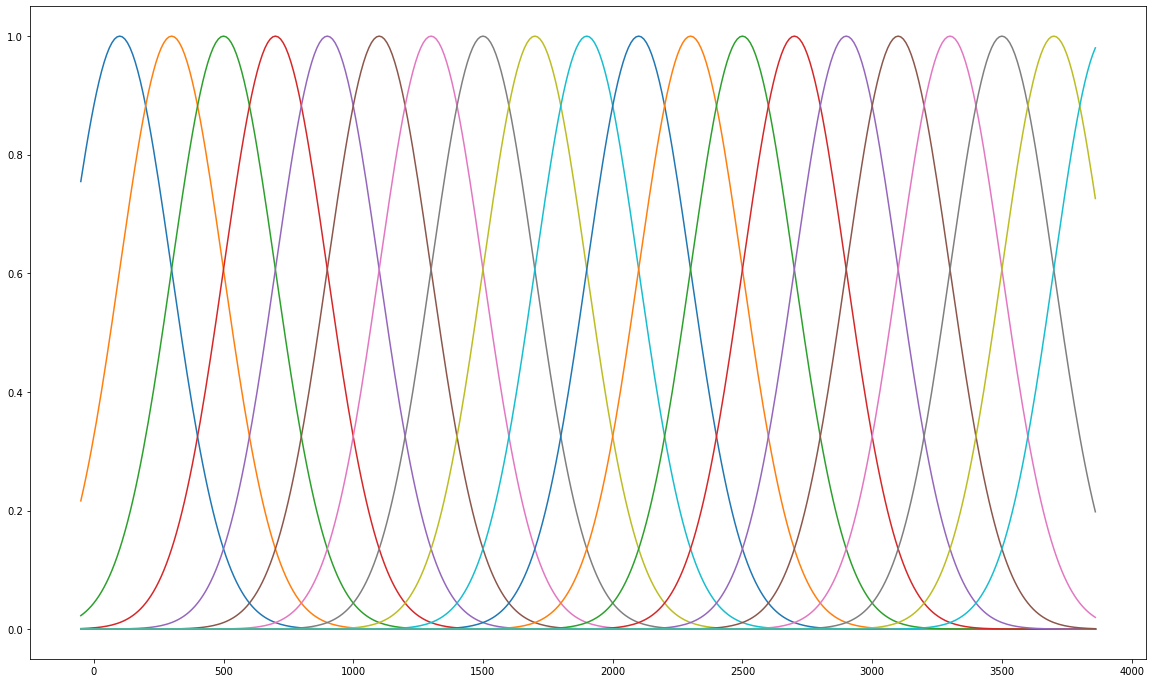

In [31]:
motion, temporal_bins, spatial_bins = estimate_motion(
    rec_preprocessed,
    peaks,
    peak_locations=peak_locations,
    direction='y',
    bin_duration_s=5.,
    bin_um=10.,
    method='decentralized_registration',
    method_kwargs={},
    non_rigid_kwargs=dict(bin_step_um=200),
    progress_bar=True,
    verbose=True,
)
print(motion.shape)
print(temporal_bins.shape)

Text(0, 0.5, 'motion [um]')

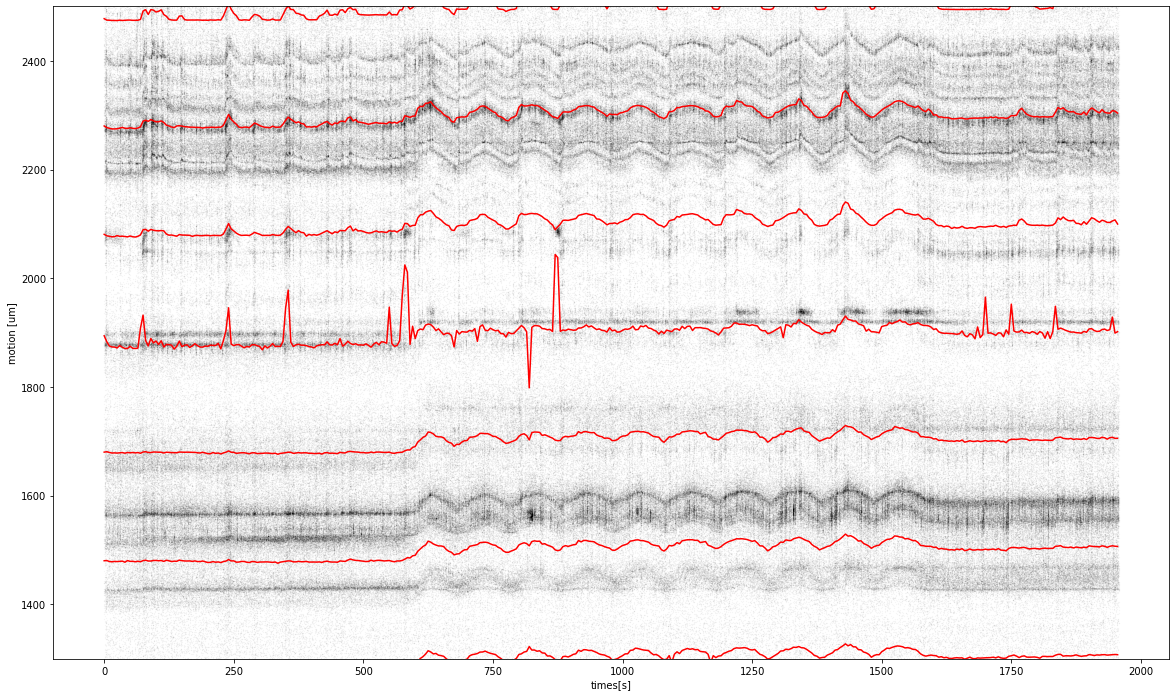

In [32]:
fs = rec_preprocessed.get_sampling_frequency()

fig, ax = plt.subplots()
ax.scatter(peaks['sample_ind'] / fs, peak_locations['y'], color='k', s=0.1, alpha=0.05)


for i, s_bins in enumerate(spatial_bins):
    # several motion vector
    ax.plot(temporal_bins[:-1], motion[:, i] + spatial_bins[i], color='r')

ax.set_ylim(1300, 2500)
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')